In [1]:
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import pandas as pd 
import seaborn as sns
from tqdm.notebook import tqdm

import ipywidgets
from ipywidgets import interact
import IPython

# If in your browser the figures are not nicely vizualized, change the following line. 
rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

import pyro.optim 
from pyro.infer import Predictive, SVI, Trace_ELBO, HMC, MCMC, NUTS, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoLaplaceApproximation
import pyro.distributions as dist

import torch 
from torch import nn
from torch.distributions import MultivariateNormal, constraints


prior_c, svi_c, mcmc_c = sns.color_palette()[:3]
lap_c = "#8ed685ed"


# Bayesian Logsitic Regression with Pyro

* Our model is $y \sim \mathcal{N}(b + w x, \sigma^2_N)$, thus the likelihood is Gaussian. 
* Our priors are 
    * $b \sim \mathcal{N}(0, \sigma^2_b)$ 
    * $w \sim \mathcal{N}(0, \sigma^2_w)$
    * $\sigma_N = |z|$ and $z \sim \mathcal{N}(0, 5)$

In [2]:
def model(x, y=None):
    b = pyro.sample("b", dist.Normal(0., 1.0))      # Bias Coefficient
    w = pyro.sample("w", dist.Normal(0., 1.0))       # Linear Coefficient
    sigma = pyro.sample("sigma", dist.HalfNormal(5.)) 
    mean = b + w * x
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

        
def guide(x, y): # custom guide
    # Define parameters.
    # bias
    b_loc = pyro.param('b_loc', torch.tensor(0.))
    b_scale = pyro.param('b_scale', torch.tensor(1.), constraint=constraints.positive)
    
    # weight
    w_loc = pyro.param('weights_loc',  torch.randn(1))
    w_scale = pyro.param('weights_scale', torch.ones(1), constraint=constraints.positive)

    # sigma
    sigma_loc = pyro.param('sigma_loc', torch.tensor(5.), constraint=constraints.greater_than(0.1))

    # Generate samples
    b = pyro.sample("b", dist.Normal(b_loc, b_scale))
    w = pyro.sample("w", dist.Normal(w_loc, w_scale))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = b + w * x 
    
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats


## Generate Data and plot the Prior

In [3]:
num_points=500
num_samples=1000

# generate data
b = dist.Normal(0, 1).sample()
w = dist.Normal(0.0, 1.0).sample()
sigma = 1
x = torch.randn(100)
test_x = torch.linspace(-3, 3, num_samples)
mean = b + x * w 
y = dist.Normal(mean, sigma).sample()

# init prior
prior_predictive = Predictive(
        model, num_samples=num_samples)
prior_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
                     for k, v in prior_predictive(x).items()
                     if k != "obs"}

In [4]:
def plot_prior_(sigma_b: float, sigma_w: float):
    num_points=100
    num_samples=1000
    test_x = torch.linspace(-3, 3, 1000)
    
    def model(x, y=None):
        b = pyro.sample("b", dist.Normal(0., sigma_b))     
        w = pyro.sample("w", dist.Normal(0., sigma_w))      
        sigma = pyro.sample("sigma", dist.Uniform(1, 5.)) 
        mean = b + w * x
        with pyro.plate("data", len(x)):
            pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

    # generate data
    b = dist.Normal(0, sigma_b).sample()
    w = dist.Normal(0., sigma_w).sample()
    sigma = dist.Uniform(1, 10.).sample()
    x = torch.randn(num_points)
    mean = b + x * w 
    y = dist.Uniform(mean - sigma, mean + sigma).sample()

    # init prior
    prior_predictive = Predictive(
        model, num_samples=num_samples)
    prior_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
                     for k, v in prior_predictive(x).items()
                     if k != "obs"}
    
    #  sample points from prior distribution
    prior_predictive_model = prior_predictive(test_x)["obs"].detach().cpu().numpy()
    mean = prior_predictive_model.mean(0)
    std = prior_predictive_model.std(0)

    with torch.no_grad():
        plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
        plt.plot(test_x, mean, 'b-', color=prior_c, label='Prior predictive mean')
        #plt.fill_between(test_x, mean - 2*std, mean + 2*std, alpha = 0.3, color=prior_c, label='Prior predictive distribution')
        plt.fill_between(test_x, mean - std, mean + std, alpha = 0.3, color=prior_c, label='Prior predictive distribution')

        plt.plot(test_x, b + test_x * w, 'k-', lw=2, label='Sampled Model (w,b)')

        plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=7)
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        plt.xlim([-3, 3])
        plt.show()

interact(
    plot_prior_,
    sigma_b = ipywidgets.FloatSlider(
        value=1, min=0.1, max=10, step=0.1, continuous_update=True),
    sigma_w = ipywidgets.FloatSlider(
        value=1, min=0.1, max=10, step=0.1, continuous_update=True)
);

interactive(children=(FloatSlider(value=1.0, description='sigma_b', max=10.0, min=0.1), FloatSlider(value=1.0,…

## Laplace Approximation

Here we approximate the posterior using

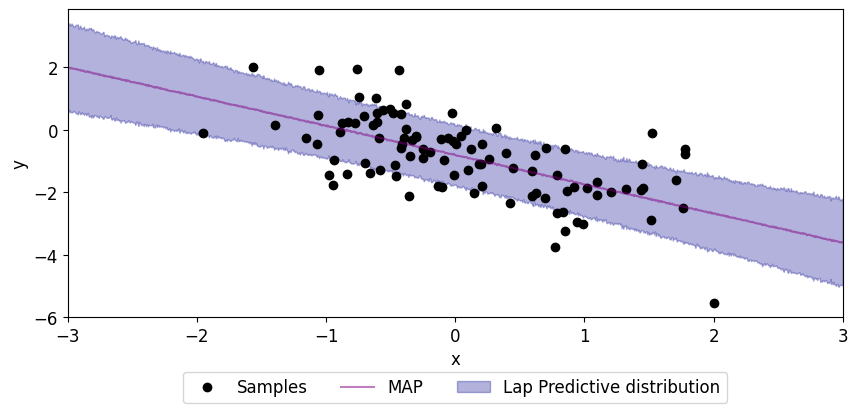

In [5]:
# load variational
delta_guide = AutoLaplaceApproximation(model) 
svi = SVI(model, delta_guide, pyro.optim.Adam({"lr": 1e-2}), loss=Trace_ELBO())
pyro.clear_param_store()

num_iters = 500
elbo = []
for i in range(num_iters):
    elbo.append(svi.step(x, y))

laplace_guide = delta_guide.laplace_approximation(x)
latents = laplace_guide.get_posterior().sample((1000,))
lap_samples =  {"b": latents[:,0], "w": latents[:,1], "sigma": torch.abs(latents[:,2])}
post_samps = {"b": latents[:,0].unsqueeze(-1), "w": latents[:,1].unsqueeze(-1), "sigma": torch.abs(latents[:,2].unsqueeze(-1))}

lap_predictive = Predictive(model, posterior_samples=post_samps, num_samples=num_samples)
lap_predictive_model = lap_predictive.get_samples(test_x, None)["obs"]

with torch.no_grad():
    mean = lap_predictive_model.mean(0)
    std = lap_predictive_model.std(0)
    plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    plt.plot(x, y, 'ko', label='Samples')
    plt.plot(test_x, mean, color="purple", alpha=0.5, label='MAP')
    plt.fill_between(test_x, mean - 3*std, mean + 3*std, alpha = 0.3, color="darkblue", label='Lap Predictive distribution')

    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=7)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-3, 3])
    
    plt.show();

## Stochastic Variational Inference

  0%|          | 0/500 [00:00<?, ?it/s]

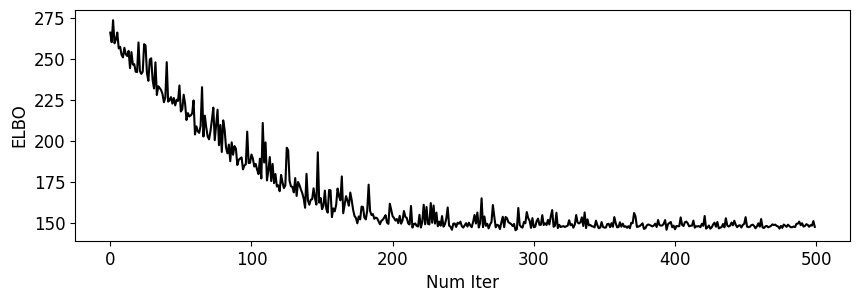

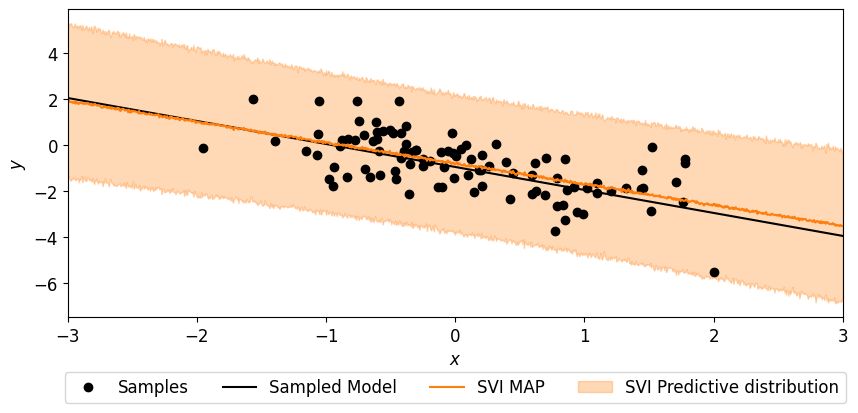

In [6]:
svi = SVI(model,
          guide,
          pyro.optim.Adam({"lr": 1e-2}),
          loss=Trace_ELBO())
pyro.clear_param_store()
num_iters = 500
elbo = []
for i in tqdm(range(num_iters)):
    elbo.append(svi.step(x, y))

plt.figure(figsize=[10,3])
plt.plot(elbo, color="k")
plt.xlabel('Num Iter')
plt.ylabel('ELBO')
plt.show()


svi_predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in svi_predictive(x, y).items()
               if k != "obs"}

svi_predictive_model = svi_predictive(test_x, torch.randn(1000))["obs"].detach().cpu().numpy()
mean = svi_predictive_model.mean(0)
std = svi_predictive_model.std(0)

svi_predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_predictive_model = svi_predictive.get_samples(test_x, None)["obs"]

with torch.no_grad():
    mean = svi_predictive_model.mean(0)
    std = svi_predictive_model.std(0)
    plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    plt.plot(x, y, 'ko', label='Samples')
    plt.plot(test_x, b + test_x * w, 'k-', label='Sampled Model')
    plt.plot(test_x, mean, color=svi_c, label='SVI MAP')
    plt.fill_between(test_x, mean - 3 * std, mean + 3 * std, alpha = 0.3, color=svi_c, label='SVI Predictive distribution')
    
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=7)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xlim([-3,3])
    plt.show();

## Demo Guide:

#### some explanation
To understand the above stochastic variational inference
- Samples: Sample from the real model points
- Sampled Model: The real model line (except for sigma)
- Prior MAP: The predictive distribution. More detail in [Predictive](https://docs.pyro.ai/en/stable/inference_algos.html#module-pyro.infer.predictive)


## Markov Chain Monte Carlo (Hamiltonian MC)

Sample: 100%|█| 1200/1200 [00:05, 228.34it/s, step size=8.31e-01, acc. prob=0.91


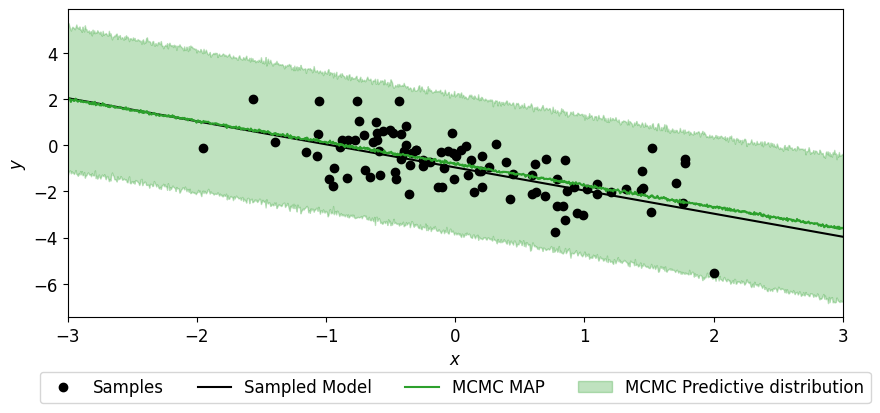

In [7]:
kernel = NUTS(model)  # HMC
mcmc = MCMC(kernel, num_samples=1000, warmup_steps=200)
mcmc.run(x, y)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
    
mcmc_predictive_samples = Predictive(model, posterior_samples=mcmc.get_samples())(test_x, None)["obs"]

with torch.no_grad():
    mean = mcmc_predictive_samples.mean(0)
    std = mcmc_predictive_samples.std(0)
    plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
    plt.plot(x, y, 'ko', label='Samples')
    plt.plot(test_x, b + test_x * w, 'k-', label='Sampled Model')
    plt.plot(test_x, mean, color=mcmc_c, label='MCMC MAP')
    plt.fill_between(test_x, mean - 3 * std, mean + 3 * std, alpha = 0.3, color=mcmc_c, label='MCMC Predictive distribution')
    
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=7)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xlim([-3,3])
    plt.show();


# Compare Posterior of Regression Coefficients
We plot the priors for reference (blue), as well as the true values used to generate training data.

* Laplacian approx.
* SVI
* MCMC (HMC)



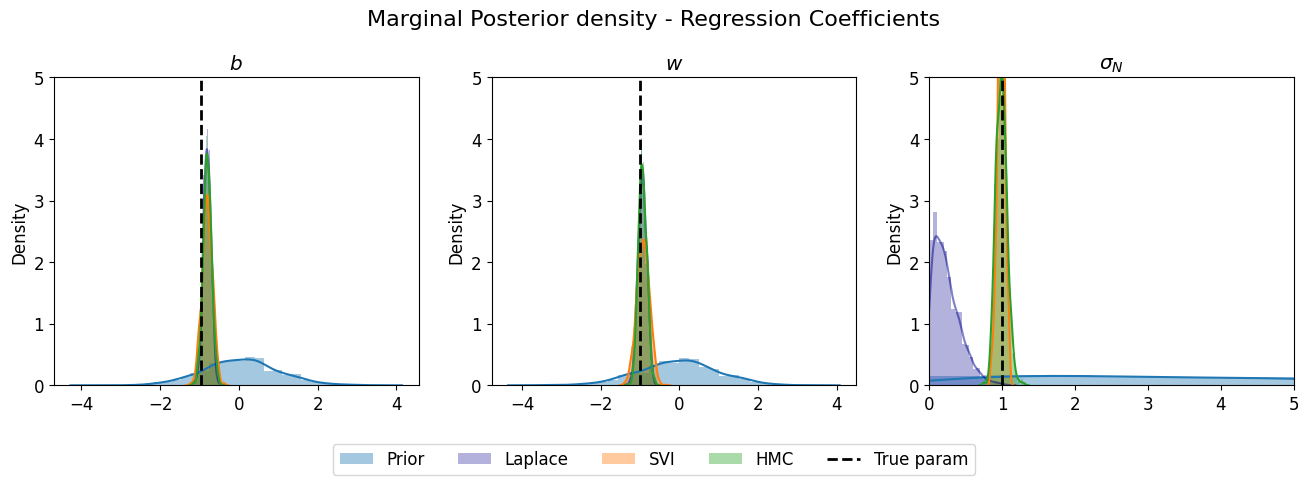

In [8]:
sites = ["b", "w", "sigma"]
values = {"b": b, "w": w, "sigma": sigma}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle("Marginal Posterior density - Regression Coefficients", y=1.05, fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(prior_samples[site], ax=ax, label="Prior", color=prior_c, norm_hist=True)
    sns.distplot(lap_samples[site].numpy(), ax=ax, label="Laplace", color="darkblue", hist_kws={"alpha":0.3}, kde_kws={"alpha":0.5}, norm_hist=True)
    sns.distplot(svi_samples[site], ax=ax, label="SVI", color=svi_c, norm_hist=True)
    sns.distplot(hmc_samples[site], ax=ax, label="HMC", color=mcmc_c, norm_hist=True)
    ax.axvline(x=values[site], color='k', lw=2, linestyle='dashed', label='True param')
    if i == 2:
        ax.set_title("$\sigma_N$")
    else:
        ax.set_title(f"${site}$")
    axs[i].set_ylim([0, 5])

axs[2].set_xlim([-0, 5])
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.015), loc='upper center', ncol=7);
